In [1]:
# import required libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import metrics

from pydeseq2.preprocessing import deseq2_norm_fit, deseq2_norm_transform

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
# initialize random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

#### 1. Import data

- Import training and test sets for X and y, where X contains raw gene expression counts from RNA-seq and y contains the subtype labels. Ensure that the rows in X and y correspond to the same samples.   
- Import the differentially expressed genes (DEGs), which were identified using DESeq2 based only on the training set. The test set was excluded from DEG selection to prevent data leakage during model evaluation. The DEGs include genes consistenly upregulated and downregulated in each of the subtypes with absolute log2 fold change > 1 and adjusted p-value < 0.05, to ensure strong biological relevance and statistical significance.

**Note**: View the first few rows of all the imported datasets to check whether the row and column indices are properly set. Eg:

- X: row indices == sample ids, column indices == gene ids
- y: row indices == sample ids, column index == subtype label

In [3]:
X_train = pd.read_csv("C:/Users/User/Documents/brca_subtype_ae/data/train_test_sets/X_raw_counts_train.csv", 
                      header=0, index_col=0)

In [4]:
y_train = pd.read_csv("C:/Users/User/Documents/brca_subtype_ae/data/train_test_sets/y_subtype_train.csv", 
                      header=0, index_col=0)

In [5]:
X_test = pd.read_csv("C:/Users/User/Documents/brca_subtype_ae/data/train_test_sets/X_raw_counts_test.csv",
                     header=0, index_col=0)

In [6]:
y_test = pd.read_csv("C:/Users/User/Documents/brca_subtype_ae/data/train_test_sets/y_subtype_test.csv", 
                      header=0, index_col=0)

In [7]:
degs = pd.read_csv("C:/Users/User/Documents/brca_subtype_ae/data/train_test_sets/degs_training_set.csv",
                   header=0, index_col=0)

In [8]:
print(f"Size of training set (X): {X_train.shape}")
print(f"Size of training set (y): {y_train.shape}")
print(f"Size of test set (X): {X_test.shape}")
print(f"Size of test set (y): {y_test.shape}")
print(f"Size of DEGs: {degs.shape}")

Size of training set (X): (721, 60660)
Size of training set (y): (721, 1)
Size of test set (X): (310, 60660)
Size of test set (y): (310, 1)
Size of DEGs: (4219, 1)


In [9]:
# check if row names (sample ids) in both X and y match for both training and test sets
# outputs should be 'True' for both
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))

True
True


In [10]:
# check the proportion of each class in training and test sets
print("Proportion of each class in the training set:")
print(y_train.value_counts())

print("\nProportion of each class in the test set:")
print(y_test.value_counts())

Proportion of each class in the training set:
paper_BRCA_Subtype_PAM50
LumA                        388
LumB                        146
Basal                       130
Her2                         57
Name: count, dtype: int64

Proportion of each class in the test set:
paper_BRCA_Subtype_PAM50
LumA                        167
LumB                         63
Basal                        55
Her2                         25
Name: count, dtype: int64


#### 2. Initial data preparation 
- Since classification will be performed with a Random Forest which expects numerical labels, the class labels (y) are encoded as integers using Label Encoding.
-  Subset both the training and test X sets to include only the DEGs identified from the training set, excluding all other genes. Only DEGs are kept to build a simpler autoencoder model and minimize noise from irrelevant genes for efficient training.

In [11]:
# label encoding of subtype labels in 'y' 
# convert the encoded 'y' into dataframes to be able to split by indices during cross-validation 
label_encoder = LabelEncoder()
y_train_encoded = pd.DataFrame(label_encoder.fit_transform(y_train.iloc[:,0]), columns=y_train.columns, index=y_train.index)
y_test_encoded = pd.DataFrame(label_encoder.transform(y_test.iloc[:,0]), columns=y_test.columns, index=y_test.index)

# check the proportion of each class after label encoding
print("Proportion of each class in the training set:")
print(y_train_encoded.value_counts())

print("\nProportion of each class in the test set:")
print(y_test_encoded.value_counts())

Proportion of each class in the training set:
paper_BRCA_Subtype_PAM50
2                           388
3                           146
0                           130
1                            57
Name: count, dtype: int64

Proportion of each class in the test set:
paper_BRCA_Subtype_PAM50
2                           167
3                            63
0                            55
1                            25
Name: count, dtype: int64


After label encoding, the class labels are encoded as follows:

- Basal-like -> 0
- Her2-enriched -> 1
- Luminal A -> 2
- Luminal B -> 3

In [12]:
# keep only DEGs in the training and test sets
X_train_deg = X_train[degs['ensembl_gene_id'].tolist()]
X_test_deg = X_test[degs['ensembl_gene_id'].tolist()]
print(f"Size of training set (X) after subsetting DEGs: {X_train_deg.shape}")
print(f"Size of test set (X) after subsetting DEGs: {X_test_deg.shape}")

Size of training set (X) after subsetting DEGs: (721, 4219)
Size of test set (X) after subsetting DEGs: (310, 4219)


#### 3. RNA-seq Data Preprocessing

After initial data preparation, raw counts are transformed using a custom preprocessing pipeline to adjust for technical factors and make them compatible with machine learning models.
The pipeline includes:
1. Median-of-ratios normalization using PyDESeq2 [Muzellec et al., 2023](https://pmc.ncbi.nlm.nih.gov/articles/PMC10502239/) to adjust for sequencing depth and library composition biases. More details on the type of RNA-seq data normalization and the factors they correct for can be  found [here](https://hbctraining.github.io/DGE_workshop_salmon/lessons/02_DGE_count_normalization.html).
2. Log2 transformation (adding a pseudocount of 1) to stabilize variance and reduce skewness in gene expression counts.
3. Min-max scaling to [0, 1] for all features (genes) to ensure that the model treats all features equally, because features with large ranges can dominate model training.

The function `preprocess_rnaseq()` will apply this pipeline to both training and test datasets. It returns the preprocessed datasets ready to be passed to the model.

##### Function: `preprocess_rnaseq()`

In [13]:

def preprocess_rnaseq(x_train, x_val):
    """
    Preprocess RNA-seq raw count data for training and validation/test sets with 
    PyDESeq2 median-of-ratios normalization, log2 transform, and min-max scaling.
    
    Parameters
    ----------
    x_train : pd.DataFrame, shape (n_samples, n_features)
        Training data raw counts.
    x_val : pd.DataFrame, (n_samples, n_features)
        Validation/test data raw counts.
    
    Returns
    -------
    x_train_scaled : np.array, shape (n_samples, n_features)
        Normalized, log2-transformed, and scaled training data.
    x_val_scaled : np.array, shape (n_samples, n_features)
        Normalized, log2-transformed, and scaled validation/test data.
    """ 
    # perform pydeseq2 median of ratios normalization
    logMeans, filteredGenes = deseq2_norm_fit(x_train)
    x_train_deseq2 = deseq2_norm_transform(x_train, logMeans, filteredGenes)[0]
    x_val_deseq2 = deseq2_norm_transform(x_val, logMeans, filteredGenes)[0]
    
    # perform log2 transformation with a pseudocount of 1 
    x_train_log2 = np.log2(x_train_deseq2 + 1)
    x_val_log2 = np.log2(x_val_deseq2 + 1)
   
    # perform min max scaling
    # scaler = MinMaxScaler()
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train_log2)
    x_val_scaled = scaler.transform(x_val_log2)

    return x_train_scaled, x_val_scaled

#### 4. Autoencoder-Random Forest Model



A hybrid framework is used to classify breast cancer subtypes, consisting of two components: an autoencoder (AE) for feature compression and a random forest (RF) for classification.  RF was selected because it can learn complex, non-linear relationships; is not sensitive to feature scaling; and is easy to train.

Autoencoder (AE) comprises:  
  - Encoder: compresses the input expression data of the DEGs into a lower-dimensional latent representation.  
  - Bottleneck: contains the compressed features.  
  - Decoder: reconstructs the input from the bottleneck features
   
In this project, both encoder and decoder consists of only one layer each. The architecture is kept simple because the input dimensionality has been reduced by selecting only differentially expressed genes. 

The AE-RF framework is implemented as follows:  
1. Train the AE on the training set.
2. Extract the encoder (up to the bottleneck) from the trained AE.
3. Use the encoder to extract compressed (bottleneck) features from both the training and test sets.
4. Train the RF on the training set’s AE-extracted features.
5. Predict breast cancer subtypes for the test set using its AE-extracted features as input to the trained RF. 

Some parts of the framework will be implemented through separate functions, so that they can be reused easily anywhere in the code without copying it every time, and make the code look clean. 

##### Function: `build_autoencoder()`

In [14]:
def build_autoencoder(x_train, encoder_layer_size, bottleneck_layer_size, activation_function, learning_rate, seed):
    """
    Compiles and returns autoencoder with encoder, bottleneck and decoder for compressing RNA-seq normalized data.
    Model architecture can be customized by changing the function arguments.
    The autoencoder is compiled with MSE loss and Adam optimizer.

    Parameters
    ----------
    x_train: np.ndarray, shape (n_samples, n_features)
        Input data to determine input layer dimension.
    encoder_size: int
        Number of units in the encoder. This is same for decoder as well.
    bottleneck_size: int
        Number of units in the bottleneck layer.
    activation : str
        Activation function used in the encoder and decoder layers.
    learning_rate : float
        Learning rate for the Adam optimizer.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    autoencoder : keras Model
        Compiled autoencoder model ready for training.
    """
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    # build autoencoder
    n_inputs = x_train.shape[1]
    input_layer = Input(shape=(n_inputs,), name="input_layer")
    enc_layer_1 = Dense(encoder_layer_size, kernel_initializer="glorot_uniform", name="enc_layer_1", activation=activation_function)(input_layer)
    bottleneck = Dense(bottleneck_layer_size, kernel_initializer="glorot_uniform", name="bottleneck")(enc_layer_1)
    dec_layer_1 = Dense(encoder_layer_size, kernel_initializer="glorot_uniform", name="dec_layer_1", activation=activation_function)(bottleneck)
    output_layer = Dense(n_inputs, kernel_initializer="glorot_uniform", name="output_layer")(dec_layer_1)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return autoencoder   

##### Function: `get_bottleneck_features()`

In [15]:
def get_bottleneck_features(autoencoder, x_train, x_validation, seed):
    """
    Extracts compressed features from the bottleneck layer of an autoencoder. 
    Extracted features can be used for downstream tasks like visualization and training a classifier.

    Parameters
    ----------
    autoencoder : keras Model
        A trained autoencoder model containing an encoder, bottleneck, and decoder.
    x_train : np.ndarray 
        Training data (preprocessed) to extract bottleneck features from.
    x_val : np.ndarray
        Validation or test data (preprocessed) to extract bottleneck features from.

    Returns
    -------
    x_train_compressed : np.ndarray
        Compressed feature representation of the training data from the bottleneck layer.
    x_val_compressed : np.ndarray
        Compressed feature representation of the validation/test data from the bottleneck layer.

    """
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    # build a feature extractor model from the trained autoencoder which outputs features from the bottleneck layer
    input_layer = autoencoder.input
    bottleneck_layer = autoencoder.get_layer("bottleneck").output
    feature_extractor = Model(inputs=input_layer, outputs=bottleneck_layer)

    # get the bottleneck layer features of both training and validation/test sets
    x_train_compressed = feature_extractor.predict(x_train)
    x_val_compressed = feature_extractor.predict(x_validation)

    return x_train_compressed, x_val_compressed
    

#### 5. AE-RF Framework Development and Evaluation

The AE-RF framework was developed and evaluated in two stages: 5-fold stratified cross-validation for hyperparameter tuning and test set evaluation for assessing generalization.

**Why Cross-validation?**
Cross-validation is preferred over single validation for selecting hyperparameters in this case because the dataset used is moderately sized (training set size: 721). Cross-validation trains and tests the model on different subsets of the data. It provides a more robust estimate of the model's performance on unseen data because the performance metrics are averaged across the folds. This helps reduce variance and bias in hyperparameter selection, so the selected hyperparameters are more likely to result in stable model performance. On the other hand, a single validation set might not be representative of the entire dataset, and choosing hyperparameters based on it increases the risk of overfitting, leading to poor generalization to unseen data.

**Strategy for Cross-Validation**:
5-fold stratified cross-validation was used. Stratification ensures that class proportions are preserved in each fold. 5 folds were chosen (instead of 10) to retain enough data in each validation fold. Only the training set was used for cross-validation; the test set was excluded to avoid data leakage during hyperparameter tuning. AE architecture and training hyperparameters were selected based on maximizing the macro-averaged F1 score. For RF, the default hyperparameters were used, as they are generally robust for classification.

For model evaluaton, a function named `compute_metrics()` was defined to compute and store the peformance metrics in a dictionary.

##### Function: `compute_metrics()`:

In [16]:
def compute_metrics(y_actual, y_pred, average_type):
    """
    Calculate accuracy, precision, recall and F1 scores based on actual and predicted class labels.

    Parameters
    ----------
    y_actual : pd.DataFrame or np.ndarray
        Actual class labels.
    y_pred : pd.DataFrame or np.ndarray
        Predicted class labels.
    average_type : str
        Type of averaging performed on the scores. Applicable for multiclass targets.
        Options: 'macro', 'micro', 'weighted'

    Returns
    -------
    metric_dict : dictionary
        A dictionary of metrics and their corresponding scores
    """
    accuracy = metrics.accuracy_score(y_actual, y_pred)
    precision = metrics.precision_score(y_actual, y_pred, average=average_type)
    recall = metrics.recall_score(y_actual, y_pred, average=average_type)
    f1 = metrics.f1_score(y_actual, y_pred, average=average_type)
    
    metric_dict = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}
    
    return metric_dict
    

##### Hyperparameters for AE

In [17]:
enc_size = 800
bneck_size = 150
activation_func = 'relu'
lr = 0.0001
epochs = 40
batch_size = 64

#### 5.1 Cross-Validation

In [18]:
tf.random.set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
fold = 1

# create an empty dataframe to append metric scores of each CV fold
cv_scores_df = pd.DataFrame(index=[i for i in range(1, 6)], columns=['Accuracy', 'Precision', 'Recall', 'F1'])
cv_scores_df.index.name = 'Fold'

# create an empty dataframe to add training and validation loss of each epoch for each CV fold
train_cv_loss_df = pd.DataFrame(index=[i for i in range(1, epochs+1)])
val_cv_loss_df = pd.DataFrame(index=[i for i in range(1, epochs+1)])
train_cv_loss_df.index.name = 'Epoch'
val_cv_loss_df.index.name = 'Epoch'

for train_index, val_index in stratified_k_fold.split(y_train_encoded, y_train_encoded):
    print(f"Starting fold {fold}\n")
    
    # split the training set into train and validation sets for 5-fold cross validation
    x_cv_train, x_cv_val = X_train_deg.iloc[train_index], X_train_deg.iloc[val_index]
    y_cv_train, y_cv_val = y_train_encoded.iloc[train_index], y_train_encoded.iloc[val_index]

    # preprocess x train and validation sets using preprocess_rnaseq()
    x_cv_train_scaled, x_cv_val_scaled = preprocess_rnaseq(x_cv_train, x_cv_val)

    # create autoencoder
    cv_auc = build_autoencoder(x_train=x_cv_train, encoder_layer_size=enc_size, bottleneck_layer_size=bneck_size, 
                            activation_function=activation_func, learning_rate=lr, seed=SEED)
    
    # setup tensorboard to visualize training across folds (can be opened with this command in prompt: tensorboard --logdir file path)
    cv_log_dir = f"cv_logs/fold_{fold}"
    cv_tensorboard_callback = TensorBoard(log_dir=cv_log_dir, histogram_freq=1)

    # train autoencoder
    cv_history = cv_auc.fit(x_cv_train_scaled, x_cv_train_scaled, batch_size = batch_size, 
                            epochs = epochs, shuffle = True, validation_data=(x_cv_val_scaled, x_cv_val_scaled), verbose=0, 
                            callbacks=[cv_tensorboard_callback])

    # save training and validation loss from training history
    cv_train_loss = cv_history.history['loss']
    cv_val_loss = cv_history.history['val_loss']
    train_cv_loss_df[f'Fold_{fold}'] = cv_train_loss 
    val_cv_loss_df[f'Fold_{fold}'] = cv_val_loss

    # train RF with bottleneck layer features of the training set
    x_cv_train_bottleneck, x_cv_val_bottleneck = get_bottleneck_features(autoencoder=cv_auc, x_train=x_cv_train_scaled, 
                                                                         x_validation=x_cv_val_scaled, seed=SEED)
    cv_rfc = RandomForestClassifier(random_state=SEED)
    cv_rfc.fit(x_cv_train_bottleneck, y_cv_train.values.ravel())

    # make predictions on the bottleneck features of the validation set and get performance metrics
    y_cv_val_pred = cv_rfc.predict(x_cv_val_bottleneck)
    cv_scores_df.loc[fold] = compute_metrics(y_actual=y_cv_val, y_pred=y_cv_val_pred, average_type='macro')
    print(metrics.classification_report(y_cv_val, y_cv_val_pred, digits=4))

    fold += 1
    

Starting fold 1

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
              precision    recall  f1-score   support

           0     0.9600    0.9231    0.9412        26
           1     0.8462    0.9167    0.8800        12
           2     0.8889    0.9231    0.9057        78
           3     0.7692    0.6897    0.7273        29

    accuracy                         0.8759       145
   macro avg     0.8661    0.8631    0.8635       145
weighted avg     0.8742    0.8759    0.8742       145

Starting fold 2

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9615    0.9804        26
           1     0.7778    0.6364    0.7000        11
           2     0.9167    0.9872    0.9506        78
           3     0.8077    0.7241    0.7636        29

    accuracy                         0.9028       144
   macro avg     0.8755    0.8273    0.8487       1

##### Model Performance During Cross-Validation

In [19]:
for met in cv_scores_df.columns:
    mean_score = round(cv_scores_df[met].mean(), 4)
    std_score = round(cv_scores_df[met].std(), 4)
    print(f"Mean {met}: {mean_score} \u00B1 {std_score}") 

Mean Accuracy: 0.8974 ± 0.0208
Mean Precision: 0.8982 ± 0.0266
Mean Recall: 0.8674 ± 0.0243
Mean F1: 0.8799 ± 0.0232


##### Training and Validation Mean Loss Curves of Cross-Validation

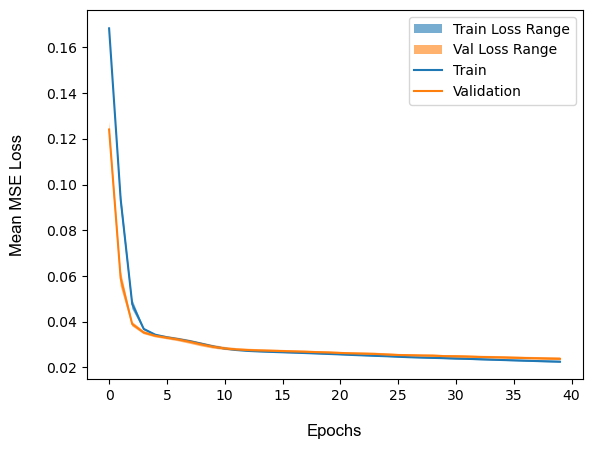

In [33]:
mean_train_loss = train_cv_loss_df.mean(axis=1).values
mean_val_loss = val_cv_loss_df.mean(axis=1).values
std_train_loss = train_cv_loss_df.std(axis=1).values
std_val_loss = val_cv_loss_df.std(axis=1).values
epoch_range = np.arange(len(mean_train_loss))

plt.fill_between(epoch_range, mean_train_loss-std_train_loss, mean_train_loss+std_train_loss, alpha=0.6, label='Train Loss Range')
plt.fill_between(epoch_range, mean_val_loss-std_val_loss, mean_val_loss+std_val_loss, alpha=0.6, label='Val Loss Range')
plt.plot(epoch_range, mean_train_loss, label='Train')
plt.plot(epoch_range, mean_val_loss, label='Validation')
plt.xlabel('Epochs', fontsize=12, fontfamily='Arial', labelpad=15)
plt.ylabel('Mean MSE Loss', fontsize=12, fontfamily='Arial', labelpad=15)
plt.legend()

# plt.savefig('cross_val_loss_curve.png', dpi=300, bbox_inches="tight")
plt.show()

##### Analysis

AE-RF demonstrates stable performance during cross-validation as evidenced by low standard deviation and smoothly decreasing loss curves. Both training and validation MSE loss curves decreased steeply during the first 5 epochs, then continued to decrease more gradually. Up to around 35 epochs, validation loss overlaps with training loss. This means the compressed bottleneck features are generalizable enough for reconstruction. After this point, validation loss became slightly higher than training loss, which indicates the onset of mild overfitting. As for performance metric scores, the average precision is quite high (89%), but the recall is slightly lower (86%).

#### 5.2 Test Set Evaluation

- Build new AE-RF with the selected hyperparameters.
- Train on the entire training set.
- Evaluate on the test set.

In [21]:
# preprocess training set (full) and test set
X_train_scaled, X_test_scaled = preprocess_rnaseq(X_train_deg, X_test_deg)

# train AE-RF with the full training set
auc = build_autoencoder(x_train=X_train_deg, encoder_layer_size=enc_size, bottleneck_layer_size=bneck_size, 
                        activation_function=activation_func, learning_rate=lr, seed=SEED)

history = auc.fit(X_train_scaled, X_train_scaled, batch_size = batch_size, 
                  epochs = epochs, shuffle = True, validation_data=(X_test_scaled, X_test_scaled), verbose=0)

X_train_bottleneck, X_test_bottleneck = get_bottleneck_features(autoencoder=auc, x_train=X_train_scaled, 
                                                                     x_validation=X_test_scaled, seed=SEED)
rfc = RandomForestClassifier(random_state=SEED)
rfc.fit(X_train_bottleneck, y_train_encoded.values.ravel())

# predict test set
y_test_pred = rfc.predict(X_test_bottleneck)
test_set_scores = compute_metrics(y_actual=y_test_encoded, y_pred=y_test_pred, average_type='macro')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


##### Model Performance Metrics on Test Set

In [22]:
for key in test_set_scores.keys():
    print(f"{key}: {round(test_set_scores[key], 4)}")

Accuracy: 0.8774
Precision: 0.8983
Recall: 0.8353
F1: 0.8616


##### Training and Test Set Loss Curves

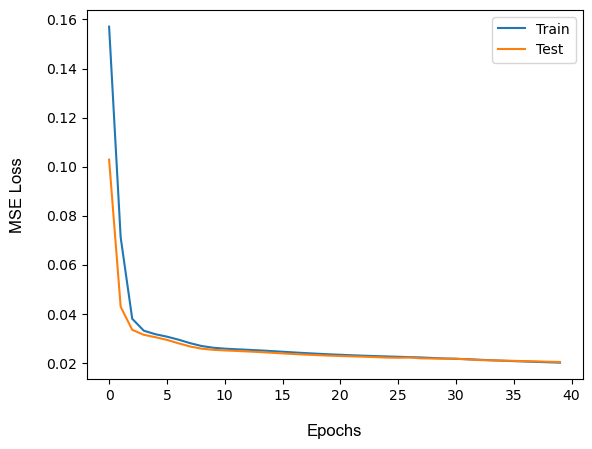

In [31]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Epochs', fontsize=12, fontfamily='Arial', labelpad = 15)
plt.ylabel('MSE Loss', fontsize=12, fontfamily='Arial', labelpad = 15)
plt.legend()

# plt.savefig('test_set_loss_curve.png', dpi=300, bbox_inches="tight")
plt.show()

##### Analysis

AE-RF shows good generalization on the test set, as the performance metric scores and loss curves are similar to those observed in cross-validation. However, as seen in cross-validation, the recall on the test set is lower than the precision. 

##### Confusion Matrix of Test Set

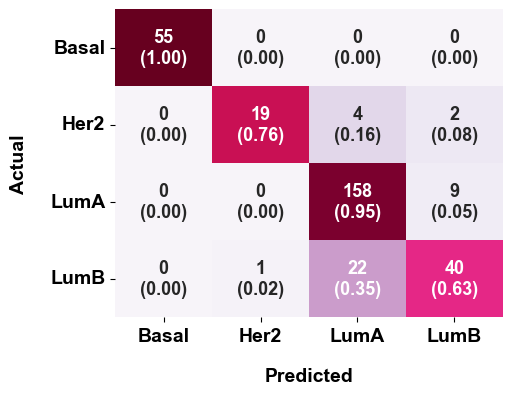

In [34]:
cm_actual = metrics.confusion_matrix(y_test_encoded.values.ravel(), y_test_pred, labels=[0,1,2,3])
cm_normalized = metrics.confusion_matrix(y_test_encoded.values.ravel(), y_test_pred, labels=[0,1,2,3], normalize='true')
new_labels = ['Basal', 'Her2', 'LumA', 'LumB']

# create annotations combining actual counts and normalized values
annotations = np.array([
    [f"{cm_actual[i, j]}\n({cm_normalized[i, j]:.2f})" for j in range(cm_actual.shape[1])]
    for i in range(cm_actual.shape[0])
])


cm_normalized_df = pd.DataFrame(cm_normalized, index=new_labels, columns=new_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_normalized_df, annot=annotations, fmt='', cmap='PuRd', cbar=False, 
            annot_kws={"size": 13, "family": 'Arial', 'weight':'bold'})
plt.xticks(fontsize=14, fontfamily='Arial', rotation=0, weight='bold')  
plt.yticks(fontsize=14, fontfamily='Arial', rotation=0, weight='bold') 
plt.xlabel('Predicted', fontsize=14, fontfamily='Arial', labelpad=16, weight='bold')
plt.ylabel('Actual', fontsize=14, fontfamily='Arial', labelpad=16, weight='bold')

# plt.savefig('ae_rf_confusion_matrix.png', dpi=300, bbox_inches="tight")
plt.show()

##### Analysis

Based on the confusion matrix, almost one third of Luminal B cases are classified as Luminal A, contributing to low recall score we saw earlier. As for HER2, its per-class recall score is low due to small sample size. The model struggles to distinguish between luminal B and luminal A probably due to several reasons:
- overlapping characteristics between both luminal subtypes arising from tumor heterogeneity
- DEGs identified as input features might have insufficient representation of luminal B class
- number of luminal B cases in the training set is not sufficient for training the model

##### PCA Visualization of Test Set Before and After Feature Compression

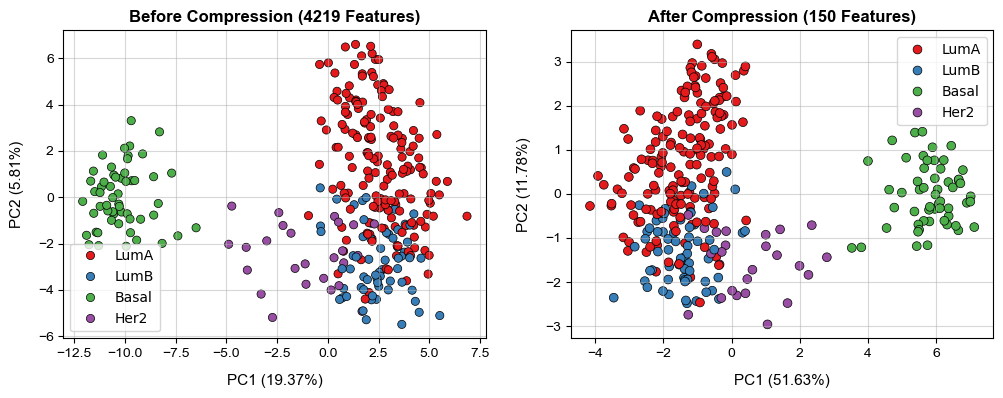

In [27]:
# pca before compression (all features)
pca_before = PCA(n_components=2, random_state=SEED)
pca_components_before = pca_before.fit_transform(X_test_scaled)
pca_components_before = pd.DataFrame(pca_components_before, columns=["PC1", "PC2"], index=X_test_deg.index)
pca_components_before = pca_components_before.join(y_test.loc[:, ['paper_BRCA_Subtype_PAM50']])
explained_variance_before = pca_before.explained_variance_ratio_

# pca after compression (bottleneck features)
pca_after = PCA(n_components=2, random_state=SEED)
pca_components_after = pca_after.fit_transform(X_test_bottleneck)
pca_components_after = pd.DataFrame(pca_components_after, columns=["PC1", "PC2"], index=X_test_deg.index)
pca_components_after = pca_components_after.join(y_test.loc[:, ['paper_BRCA_Subtype_PAM50']])
explained_variance_after = pca_after.explained_variance_ratio_

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_components_before["PC1"], 
                y=pca_components_before["PC2"], 
                hue=pca_components_before["paper_BRCA_Subtype_PAM50"],
                palette='Set1', 
                s=35, alpha=1, edgecolor='black', linewidth = 0.5)
plt.xlabel(f"PC1 ({explained_variance_before[0]*100:.2f}%)", fontsize=11, fontfamily='Arial', labelpad=10)
plt.ylabel(f"PC2 ({explained_variance_before[1]*100:.2f}%)", fontsize=11, fontfamily='Arial', labelpad=10)
plt.title("Before Compression (4219 Features)", fontsize=12, fontfamily='Arial', weight='bold')
plt.legend(loc="lower left", ncol=1, fontsize=10)
plt.xticks(fontsize=10, fontfamily='Arial')  
plt.yticks(fontsize=10, fontfamily='Arial')
plt.grid(alpha=0.5)

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_components_after["PC1"], 
                y=pca_components_after["PC2"], 
                hue=pca_components_after["paper_BRCA_Subtype_PAM50"],
                palette='Set1', 
                s=40, alpha=1, edgecolor='black', linewidth = 0.5)
plt.xlabel(f"PC1 ({explained_variance_after[0]*100:.2f}%)", fontsize=11, fontfamily='Arial', labelpad=10)
plt.ylabel(f"PC2 ({explained_variance_after[1]*100:.2f}%)", fontsize=11, fontfamily='Arial', labelpad=10)
plt.title("After Compression (150 Features)", fontsize=12, fontfamily='Arial', weight='bold')
plt.legend(loc="upper right", ncol=1, fontsize=10)
plt.xticks(fontsize=10, fontfamily='Arial')  
plt.yticks(fontsize=10, fontfamily='Arial') 
plt.grid(alpha=0.5)

# plt.savefig('pca_before_after_ae_compression.png', dpi=300, bbox_inches="tight")
plt.show()

##### Analysis

The overall structure of the expression data for 4219 DEGs is preserved even after compression through the AE, as indicated by the segregation of subtype clusters in the PCA plots. This suggests that the compressed features capture relevant information for differentiating between the subtypes. However, the boundaries between the luminal A and luminal B classes are overlapping. Further investigation is needed to establish criteria for selecting DEGs that are representative of all subtypes.